### Import libraries

In [1]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
#from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV, RFE
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
import warnings
warnings.filterwarnings("ignore")
simplefilter(action='ignore', category=FutureWarning)
from statistics import median 
import seaborn as sns
import configparser
import os

%matplotlib inline

/usr/local/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Define filename of configuration and read configuration

In [2]:
config_fn = 'config.ini'

def parse_list(config_str):
    list_in_param = [x.strip() for x in config_str.split(',')]
    return list_in_param

def parse_dict(config_str):
    removed_nl = config_str.replace('\n', '')
    return eval(removed_nl)

config = configparser.ConfigParser()
config.read(config_fn)
config_IO = config['FileIO']

file_path = config['FileIO']['file_path']
data_path = file_path + config['FileIO']['data_path']
plot_path = file_path + config['FileIO']['plot_path']
result_path = file_path + config['FileIO']['result_path']

out_paths = [plot_path, result_path]
# Create the paths if they are not exists
for out_path in out_paths:
    if not os.path.exists(out_path):
        print('Created path: ', out_path)
        os.mkdir(out_path)

<a id='preprocessing'></a>
# 1. Data acquisition and pre-processing

In [3]:
# read data file
raw_data_df = pd.read_csv(data_path+config_IO['raw_filename'])
print('Shape of raw data:', raw_data_df.shape)

Shape of raw data: (6400, 50)


### Exclude irrelevant features from analysis

In [4]:
columns_to_drop = parse_list(config['Preprocessing']['columns_to_drop'])
raw_data_df.drop(columns_to_drop, axis = 1, inplace = True)

### Remove duplicate entries from the data

In [5]:
patient_id_col = config['Preprocessing']['patient_id_column']
raw_data_df.drop_duplicates([patient_id_col],keep='first',inplace = True)
raw_data_df.drop([patient_id_col], axis=1, inplace=True)

### Select patients data with COVID-19 positive

In [6]:
filter_column = config['Preprocessing']['keep_only_matched_patient_column']
filter_value = config['Preprocessing']['keep_only_matched_patient_value']

if filter_column != 'None':
    if filter_column in raw_data_df.columns:
        raw_data_df = raw_data_df[raw_data_df[filter_column] == filter_value]
    else:
        print("'keep_only_matched_patient_column' is not one of the columns of raw data file")

'keep_only_matched_patient_column' is not one of the columns of raw data file


### Outcome labels

In [7]:
outcome_col = config['Preprocessing']['outcome_column']
y_raw_df = raw_data_df[outcome_col]
outcome_pos_value = parse_list(config['Preprocessing']['outcome_pos_value'])
outcome_neg_value = parse_list(config['Preprocessing']['outcome_neg_value'])

y_raw_df.replace(outcome_pos_value, 1, inplace=True)
y_raw_df.replace(outcome_neg_value, 0, inplace=True)

In [8]:
columns_to_drop_2 = [outcome_col]
if filter_column != 'None':
    if filter_column in raw_data_df.columns:
        columns_to_drop_2.append(filter_column)
df_dropped_outcome = raw_data_df.drop(columns_to_drop_2,axis = 1)
# print(df_dropped_outcome.info(verbose=True))

### Replacement of unknown values and tables defined in `[Preprocessing] value_replacing_dictionary` of configuration

In [9]:
# replaced unnkown, not asked etc missing variable with NaN 

unknown_value_list = parse_list(config['Preprocessing']['unknown_value'])

for u in unknown_value_list:
    df_dropped_outcome.replace(to_replace=u, value=np.nan, inplace=True)

value_replaced_dict = parse_dict(config['Preprocessing']['value_replacing_dictionary'])

for k, v in value_replaced_dict.items():
    df_dropped_outcome.replace(to_replace=k, value=v, inplace=True)
    

### Label encoded by using LabelEncoder library

In [10]:
df_dropped_outcome_obj = df_dropped_outcome.select_dtypes(include=['object']).copy()
dfTmp = df_dropped_outcome_obj
mask = dfTmp.isnull()
dfTmp = dfTmp.astype(str).apply(LabelEncoder().fit_transform)
df_LE = dfTmp.where(~mask, df_dropped_outcome_obj)

### Dropped object type variables and replaced with label encoded 

In [11]:
df_dropped_obj = df_dropped_outcome.drop(df_LE.columns.tolist(), axis = 1)
df_final = pd.concat([df_dropped_obj,df_LE], axis = 1)

### Removed features which have more than 99% constant values

In [12]:
df_features_constants = pd.DataFrame({'features':df_final.sum().index.tolist(),'values':df_final.sum().values.tolist()})
df_dropped_features_constants = df_final[df_features_constants[df_features_constants['values'] > df_final.shape[0]*0.01].features.tolist()]
X_df = df_final[df_dropped_features_constants.columns.tolist()]

### Split preprocess data in training and test set in 80% and 20% ratios

In [13]:
train_features, test_features, train_labels, test_labels = train_test_split(X_df,y_raw_df,test_size=0.2,stratify = y_raw_df, random_state=64)


### Write training set and test set in csv files

In [14]:
train_features.to_csv(data_path+config_IO['df_train'],index=False)
train_labels.to_csv(data_path+config_IO['y_train'],index=False)
test_features.to_csv(data_path+config_IO['df_test'],index=False)
test_labels.to_csv(data_path+config_IO['y_test'],index=False)
print('Finished preprocessing!')

Finished preprocessing!


### Data from 7th April preprocessed in same manner
'''Data from 7th April preprocess in similar manner and created test set2 along with its outcome variable '''

<a id='missing_value_imputation'></a>
# 2. Missing value imputation model
'''Import training set and test set along with it mortality outcome and build model to find optimum missing value cutoff'''

In [15]:


df_train = pd.read_csv(data_path + config_IO['df_train'])
y_train = pd.read_csv(data_path + config_IO['y_train'])

### Select the continous features only

In [16]:
# continous_feature = ['AGE','BMI', 'TEMPERATURE', 'TEMP_MAX', 'SYSTOLIC_BP', 'DIASTOLIC_BP', 'O2_SAT', 'O2SAT_MIN'] 
continous_feature = parse_list(config['Continuous_feature']['continuous_feature'])
X_train_cont = df_train[continous_feature]

### Used standard scaling to scal all continous features by using standard scaling libraries

In [17]:
ss = StandardScaler()
train_features_ss = pd.DataFrame(ss.fit_transform(X_train_cont), columns =  X_train_cont.columns.tolist())

### Droped continous variables from dataframe to select categorical variables

In [18]:
columns = X_train_cont.columns.tolist()
X_train_cate_miss = df_train.drop(columns,axis =1)
categorical_feature = X_train_cate_miss.columns.tolist()

### Imputation categorical features by its mode value

In [19]:
my_imputer_mf = SimpleImputer(strategy = "most_frequent")
imputed_X_train_cate = pd.DataFrame(my_imputer_mf.fit_transform(X_train_cate_miss),columns = X_train_cate_miss.columns.tolist())

### Concatenation of all continous, categorical features after imputation

In [20]:
df_train_scaled = pd.concat([train_features_ss, imputed_X_train_cate], axis=1)

### Finding highly correlated features (>0.90)

In [21]:
# Create correlation matrix
corr_matrix = df_train_scaled.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

### Droped highly correlated features from dataframe

In [22]:
df_train_scaled_dropped =  df_train_scaled.drop(to_drop , axis=1 )

In [23]:
# Train labels array
y_train_np = y_train.values

### Following function calculate Precision, Recall, F1-score Accuracy etc 

In [24]:
def precision_recall_fscore(val_labels, y_score_lr, thresholds):
    Precision_0 = []
    Recall_0 = []
    F1_scores_0 = []  
    Tn= []
    Fp= []
    Fn= []
    Tp= []
    Accu = []
    
    for i in range(0,len(thresholds)):
        y_score_lr_binary = (y_score_lr >= thresholds[i]).astype('int')
        tn, fp, fn, tp = confusion_matrix(val_labels, y_score_lr_binary).ravel()
        precision_0 = tn/(tn+fn)
        recall_0 = tn/(tn+fp)
        accu = (tp + tn)/(tp + tn + fp + fn)
        f1_scores_0 = 2*(precision_0*recall_0)/(precision_0+recall_0)
        Precision_0.append(precision_0)
        Recall_0.append(recall_0)
        F1_scores_0.append(f1_scores_0)
        Tn.append(tn)
        Fp.append(fp)
        Fn.append(fn)
        Tp.append(tp)
        Accu.append(accu)
    return(Precision_0, Recall_0, F1_scores_0,Tn, Fp, Fn, Tp, Accu )

In [34]:
def proba_score(est_model, feat):
    if hasattr(est_model, "predict_proba"):
        y_1 = est_model.predict_proba(feat)[:,1]
        y_0 = est_model.predict_proba(feat)[:,0]
    else:  # use decision function
        prob_pos = est_model.decision_function(feat)
        y_1 = prob_pos
        y_0 = -1*prob_pos
#         y_1 = \
#             (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
#         y_0 = 1 - y_1
        
    return y_1, y_0

### Following block of code is imputation model
'''In following block of code we will run missing value imputation model where we split randomly 100 times the traing data set
into 75% training and 25% validation data set. WE have calcuated (F_max, P_max, R_max, AUC, Accuracy, AUPRC and threshold 
value) of each individual model and stored into csv files for further analysis'''

In [26]:
"""
Creating Scores Container
"""  
performance_dict_final = {}
dict_clf = {'rf': RandomForestClassifier(),
            'lr': LogisticRegression(), 
            'svm': LinearSVC(), 
            'xgb': XGBClassifier()}
list_measure = ['F_max', 'P_max', 'R_max', 'thres', 'AU_PRC', 'AUC', 'Accu']
"""
For class 0
"""
performance_dict_final_0 = {}
list_measure_0 = ['F_max', 'P_max', 'R_max', 'AU_PRC']

for c, c_class in dict_clf.items():
    performance_dict_final[c] = {}
    performance_dict_final_0[c] = {}
    for m in list_measure:
        performance_dict_final[c][m] = []
    for m0 in list_measure_0:
        performance_dict_final_0[c][m0] = [] 
        

missing_percentages = range(0,61,5)

# split the data 100 times in tratified manner so that distribution of minority class remains uniform in both data sets
# split data in 75% and 25% ratios
for i in range(0,100):
    train_features, val_features, train_labels, val_labels = train_test_split(df_train_scaled_dropped,
                                                                              y_train_np,test_size=0.25,
                                                                              stratify = y_train_np)   
#     print(i)
    if i % 10 == 0:
        print('Running {}th imputation measurement...'.format(i))
    
    performance_dict = {}
    performance_dict_0 = {}

    for c, c_class in dict_clf.items():
        performance_dict[c] = {}
        performance_dict_0[c] = {}
        for m in list_measure:
            performance_dict[c][m] = []
        for m0 in list_measure_0:
            performance_dict_0[c][m0] = [] 
        
    for j in missing_percentages:# (0,61,5)
        
        # drop columns with missing  0,5,10,15,20,25....,60 % values
        train_features_cutoff = train_features[train_features.columns[(train_features.isna().mean().round(4) * 100 <=j)].tolist()]
        val_features_cutoff = val_features[train_features.columns[(train_features.isna().mean().round(4) * 100 <=j)].tolist()]

        # select the continous features of training set and validation set
        train_features_cont = train_features_cutoff[list(set(train_features_cutoff.columns.tolist()) & set(continous_feature))]
        val_features_cont = val_features_cutoff[list(set(val_features_cutoff.columns.tolist()) & set(continous_feature))]

        # select the categorical features of training set and validation set
        train_features_cate = train_features_cutoff[list(set(train_features_cutoff.columns.tolist()) & set(categorical_feature))]
        val_features_cate = val_features_cutoff[list(set(val_features_cutoff.columns.tolist()) & set(categorical_feature))]
    
    ############## Mean Mode imputation ####################################################
       # imputation continous by taking mean value of respective continous feature
        my_imputer = SimpleImputer(strategy = 'mean')
        imputed_train_features_cont = pd.DataFrame(my_imputer.fit_transform(train_features_cont),columns =train_features_cont.columns.tolist())
        imputed_val_features_cont = pd.DataFrame(my_imputer.transform(val_features_cont),columns =val_features_cont.columns.tolist())

        # imputation categorical by taking mode value of respective continous feature
        my_imputer_mf = SimpleImputer(strategy = "most_frequent")
        imputed_X_train_cate = pd.DataFrame(my_imputer_mf.fit_transform(train_features_cate),columns = train_features_cate.columns.tolist())
        imputed_X_val_cate = pd.DataFrame(my_imputer_mf.transform(val_features_cate),columns =val_features_cate.columns.tolist())

        ################## concating all continous, categorical features after imputation
        train_features_final = pd.concat([imputed_train_features_cont,imputed_X_train_cate], axis=1)
        val_features_final = pd.concat([imputed_val_features_cont,imputed_X_val_cate], axis=1)

        """
        Iterating different classifiers
        """
    
        for clf_key, clf_var in dict_clf.items():
            clf_var.fit(train_features_final, train_labels)
            y_pred = clf_var.predict(val_features_final)

            y_score, y_score_0 = proba_score(clf_var, val_features_final)
        #####################    
            precision, recall, thresholds = precision_recall_curve(val_labels, y_score)
            thresholds = np.append(thresholds, 1)
            # calculate precision-recall AUC for class 1
            au_prc = metrics.auc(recall, precision)
            f1_scores = 2*(precision*recall)/(precision+recall)
            Precision_0, Recall_0, F1_scores_0, tn, fp, fn, tp, accu = precision_recall_fscore(val_labels,  
                                                                                               y_score, 
                                                                                               thresholds)
            scrs = pd.DataFrame({'precision' : precision, 
                                 'recal' : recall, 
                                 'thresholds' : thresholds, 
                                 'f1_score':f1_scores, 
                                 'precision_0' : Precision_0, 
                                 'recal_0' : Recall_0,
                                 'f1_score_0':F1_scores_0,
                                 'Accu':accu,
                                 'tn' : tn, 
                                 'fp' :fp, 
                                 'fn' :fn, 
                                 'tp' :tp})
            fpr, tpr, th = metrics.roc_curve(val_labels, y_score, pos_label = 1)
            auc_roc = metrics.auc(fpr, tpr)  

            # calculate precision-recall AUC for class 0
            precision_0, recall_0, thresholds_0 = precision_recall_curve(val_labels, y_score_0, pos_label = 0)
            au_prc_0 = metrics.auc(recall_0, precision_0)

            f1_score  = scrs.f1_score.max() # find max f-score from scrs dataframe
            Precision = scrs.loc[scrs['f1_score'].idxmax()][0]
            Recall    = scrs.loc[scrs['f1_score'].idxmax()][1]
            Thresholds = scrs.loc[scrs['f1_score'].idxmax()][2]
#             AUC       =  auc

            Precision_0 = scrs.loc[scrs['f1_score'].idxmax()][4]
            Recall_0    = scrs.loc[scrs['f1_score'].idxmax()][5]
            f1_score_0 = scrs.loc[scrs['f1_score'].idxmax()][6]
            accu = scrs.loc[scrs['f1_score'].idxmax()][7]
#             AUC_0       =  auc_0

            """
            append calculated data of class 1
            list_measure = ['F_max', 'P_max', 'R_max', 'thres', 'AU_PRC', 'AUC', 'Accu']
            list_measure_0 = ['F_max', 'P_max', 'R_max', 'AU_PRC']  
            """
            score_list_of_clf = [f1_score, Precision, Recall, Thresholds, au_prc, auc_roc, accu]
            score_0_list_of_clf = [f1_score_0, Precision_0, Recall_0, au_prc_0]

            for m_idx, m in enumerate(list_measure):
                performance_dict[clf_key][m].append(score_list_of_clf[m_idx])
#                 print(performance_dict[c][m])
            for m0_idx, m0 in enumerate(list_measure_0):
                performance_dict_0[clf_key][m0].append(score_0_list_of_clf[m0_idx])
        
    
    for c, c_class in dict_clf.items():
        for m in list_measure:
            performance_dict_final[c][m].append(performance_dict[c][m])
#             print(c, m, '\n', performance_dict_final[c][m])
        
        for m0 in list_measure_0:
            performance_dict_final_0[c][m0].append(performance_dict_0[c][m0])

print('Done!')

Running 0th imputation measurement...
Running 10th imputation measurement...
Running 20th imputation measurement...
Running 30th imputation measurement...
Running 40th imputation measurement...
Running 50th imputation measurement...
Running 60th imputation measurement...
Running 70th imputation measurement...
Running 80th imputation measurement...
Running 90th imputation measurement...
Done!


### Built dataframes with columns (0% to 60%) missing imputation
After this, you can visualize the result by running the codes of figure 2A

In [27]:
 ######################  
    
missing_percentage_columns = ['{}%'.format(int(p)) for p in missing_percentages]

for c, c_class in dict_clf.items():
    for m in list_measure:
        df_temp = pd.DataFrame(performance_dict_final[c][m], columns=missing_percentage_columns)
        df_temp.to_csv(result_path+'df_{}_{}.csv'.format(m, c), index=False)
    for m0 in list_measure_0:
        df_temp_0 = pd.DataFrame(performance_dict_final_0[c][m0], columns=missing_percentage_columns)
        df_temp_0.to_csv(result_path+'df_{}_{}_0.csv'.format(m0, c), index=False)
        
print('Finished saving results of imputation!')

Finished saving results of imputation!


# 3.1 Recursive Feature Elimination
From missing value imputation model, we found that 20% missing value gives optimum solution and 
hence we dropped features with >20% missing values

Recursive Feature Elimination (RFE) is a feature extraction method, to select a certain number of features with optimal performance. Here we will go through RFE with RF, LR, SVM, XGB, to see how many features we should keep, to preserve the accuracy comparing to all set of features.

In [28]:
# Import again training data set
config = configparser.ConfigParser()
config.read(config_fn)
config_IO = config['FileIO']

df_train = pd.read_csv(data_path+config_IO['df_train'])
y_train = pd.read_csv(data_path+config_IO['y_train'])

In [29]:
df_train_dropped_missed  = df_train[df_train.columns[(df_train.isna().mean().round(4) * 100 <=20)].tolist()]
df_train_dropped_missed.shape

(4935, 31)

### Following block of code are same as imputation model, just removed features which have more than 20 % missing value

In [30]:
# continous_feature = ['AGE', 'TEMPERATURE', 'TEMP_MAX', 'SYSTOLIC_BP', 'DIASTOLIC_BP', 'O2_SAT', 'O2SAT_MIN'] 


X_train_cont = df_train_dropped_missed[list(set(continous_feature)&set(df_train_dropped_missed.columns.tolist()))]

# imputation of continuous features with its mean value by using SimpleImputater libraries
my_imputer = SimpleImputer(strategy = 'mean')
imputed_X_train_cont = pd.DataFrame(my_imputer.fit_transform(X_train_cont),columns = X_train_cont.columns.tolist())

# Used standard scaling to scal all continous features by using standard scaling libraries
ss = StandardScaler()
train_features_ss = pd.DataFrame(ss.fit_transform(imputed_X_train_cont), columns =  imputed_X_train_cont.columns.tolist())

# droped continous variables from dataframe to select categorical variables
columns = X_train_cont.columns.tolist()
X_cate_miss = df_train_dropped_missed.drop(columns,axis =1)

# imputation categorical features by its mode value
my_imputer_mf = SimpleImputer(strategy = "most_frequent")
imputed_X_train_cate = pd.DataFrame(my_imputer_mf.fit_transform(X_cate_miss),columns = X_cate_miss.columns.tolist())

#  concatination of all continous, categorical features after imputation
df_train_imputed = pd.concat([train_features_ss,imputed_X_train_cate], axis=1)

# Finding highly correlated features (>0.90) 
# Create correlation matrix
corr_matrix = df_train_imputed.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# droped highly correlated features from dataframe
df_train_imputed_dropped_high_corr =  df_train_imputed.drop(to_drop , axis=1 )


### Following block of code is Recursive Feature Elimination model (RFE)
'''Foolowing program ramdomly split development set into training and validation set 100 times and run recursive featuere elemination algorythms with different numbers of features. It also calculate threshold value of individual algorythm which gives highest F-max value. We stored F_max, P_max, R_max, AUC, Accuracy, AUPRC etc'''


Reading RFE Configuration

In [32]:
rfe_config = config['RFE']
total_num_feat = df_train_imputed_dropped_high_corr.shape[1]
if rfe_config['number_of_feature_to_select'] != 'ignore':
    rfe_num_features_list_str = parse_list(rfe_config['number_of_feature_to_select'])
    rfe_num_features_list_int = [int(s) for s in rfe_num_features_list_str]
elif rfe_config['step_size'] != 'ignore':
    rfe_num_features_list_int = list(range(1, total_num_feat, 
                                           int(rfe_config['step_size'])))
    if not total_num_feat in rfe_num_features_list_int:
        rfe_num_features_list_int.append(total_num_feat)
    rfe_num_features_list_int = rfe_num_features_list_int[::-1]
    rfe_num_features_list_str = [str(s) for s in rfe_num_features_list_int]
    

In [35]:
"""
Creating Scores Container
"""   
performance_rfe_dict_final = {}
dict_clf = {'rf': RandomForestClassifier(),
            'lr': LogisticRegression(), 
            'svm': LinearSVC(), 
            'xgb': XGBClassifier()}

list_measure = ['F_max', 'P_max', 'R_max', 'thres', 'AU_PRC', 'AUC', 'Accu']

"""
For class 0
"""

performance_rfe_dict_final_0 = {}
list_measure_0 = ['F_max', 'P_max', 'R_max', 'AU_PRC']

feature_rfe_list_final = {c: pd.DataFrame() for c, c_class in dict_clf.items()}

for c, c_class in dict_clf.items():
    performance_rfe_dict_final[c] = {}
    performance_rfe_dict_final_0[c] = {}
    for m in list_measure:
        performance_rfe_dict_final[c][m] = []
    for m0 in list_measure_0:
        performance_rfe_dict_final_0[c][m0] = [] 
    

# split the data 100 times in tratified manner so that distribution of minority class remains uniform in both data sets
for i in range(0,100): 
    
    train_features, val_features, train_labels, val_labels = train_test_split(df_train_imputed_dropped_high_corr,
                                                                              y_train_np, test_size=0.25,stratify = y_train_np)   
    
    
    
    performance_rfe_dict = {}
    performance_rfe_dict_0 = {}
    
    for clf_key, clf_var in dict_clf.items():
        if i % 10 == 0:
            print('{}th RFE of {} is running...'.format(i, clf_key))
        performance_rfe_dict[clf_key] = {}
        performance_rfe_dict_0[clf_key] = {}
        for m in list_measure:
            performance_rfe_dict[clf_key][m] = []
        for m0 in list_measure_0:
            performance_rfe_dict_0[clf_key][m0] = [] 
        
        
        X1 = train_features
        y1 = train_labels
        feature_name = X1.columns.tolist()

################## RFE model ##########################################

        rfe_selector = RFE(estimator=clf_var, n_features_to_select=1, step=1)
        rfe_selector.fit(X1, y1)
        rfe_support = rfe_selector.get_support()

        rank_f = rfe_selector.ranking_

        for j in rfe_num_features_list_int: # J is the number of features to select
            selected_feat = rank_f <= j

            rfe_feature = X1.loc[:,selected_feat].columns.tolist()
            ## RF model by using features selected by RFE algorithm
            train_features_final_rf = train_features[rfe_feature]
            val_features_final_rf = val_features[rfe_feature]

            clf_rfe = clf_var
            clf_rfe.fit(train_features_final_rf, train_labels)
            y_pred_rfe_svd = clf_rfe.predict(val_features_final_rf)

            y_score_rfe, y_score_rfe_0 = proba_score(clf_rfe, val_features_final_rf)
        #####################    
            precision, recall, thresholds = precision_recall_curve(val_labels, y_score_rfe)
            thresholds = np.append(thresholds, 1)
            # calculate precision-recall AUC for class 1
            au_prc = metrics.auc(recall, precision)
            f1_scores = 2*(precision*recall)/(precision+recall)
            Precision_0, Recall_0, F1_scores_0, tn, fp, fn, tp ,accu= precision_recall_fscore(val_labels,  y_score_rfe, thresholds)
            scrs = pd.DataFrame({'precision' : precision, 
                                 'recal' : recall, 
                                 'thresholds' : thresholds, 
                                 'f1_score':f1_scores, 
                                 'precision_0' : Precision_0, 
                                 'recal_0' : Recall_0,
                                 'f1_score_0':F1_scores_0,
                                 'Accu':accu,
                                 'tn' : tn, 
                                 'fp' :fp, 
                                 'fn' :fn, 
                                 'tp' :tp})
            fpr, tpr, th = metrics.roc_curve(val_labels, y_score_rfe, pos_label = 1)
            auc_roc = metrics.auc(fpr, tpr)   
            # calculate precision-recall AUC for class 0
            precision_0, recall_0, thresholds_0 = precision_recall_curve(val_labels, y_score_rfe_0, pos_label = 0)
            au_prc_0 = metrics.auc(recall_0, precision_0)

            f1_score  = scrs.f1_score.max()
            Precision = scrs.loc[scrs['f1_score'].idxmax()][0]
            Recall    = scrs.loc[scrs['f1_score'].idxmax()][1]
            Thresholds = scrs.loc[scrs['f1_score'].idxmax()][2]
#             AUC       =  auc

            Precision_0 = scrs.loc[scrs['f1_score'].idxmax()][4]
            Recall_0    = scrs.loc[scrs['f1_score'].idxmax()][5]
            f1_score_0 = scrs.loc[scrs['f1_score'].idxmax()][6]
            accu = scrs.loc[scrs['f1_score'].idxmax()][7]
#             AUC_0       =  auc_0

            """
            append calculated data of class 1
            list_measure = ['F_max', 'P_max', 'R_max', 'thres', 'AU_PRC', 'AUC', 'Accu']
            list_measure_0 = ['F_max', 'P_max', 'R_max', 'AU_PRC']  
            """
            score_list_of_clf = [f1_score, Precision, Recall, Thresholds, au_prc, auc_roc, accu]
            score_0_list_of_clf = [f1_score_0, Precision_0, Recall_0, au_prc_0]

            for m_idx, m in enumerate(list_measure):
                performance_rfe_dict[clf_key][m].append(score_list_of_clf[m_idx])
#                 print(performance_dict[c][m])
            for m0_idx, m0 in enumerate(list_measure_0):
                performance_rfe_dict_0[clf_key][m0].append(score_0_list_of_clf[m0_idx])

    for c, c_class in dict_clf.items():
        for m in list_measure:
            performance_rfe_dict_final[c][m].append(performance_rfe_dict[c][m])
    #             print(c, m, '\n', performance_dict_final[c][m])

        for m0 in list_measure_0:
            performance_rfe_dict_final_0[c][m0].append(performance_rfe_dict_0[c][m0])

print('Done!')

0th RFE of rf is running...
0th RFE of lr is running...
0th RFE of svm is running...
0th RFE of xgb is running...
10th RFE of rf is running...
10th RFE of lr is running...
10th RFE of svm is running...
10th RFE of xgb is running...
20th RFE of rf is running...
20th RFE of lr is running...
20th RFE of svm is running...
20th RFE of xgb is running...
30th RFE of rf is running...
30th RFE of lr is running...
30th RFE of svm is running...
30th RFE of xgb is running...
40th RFE of rf is running...
40th RFE of lr is running...
40th RFE of svm is running...
40th RFE of xgb is running...
50th RFE of rf is running...
50th RFE of lr is running...
50th RFE of svm is running...
50th RFE of xgb is running...
60th RFE of rf is running...
60th RFE of lr is running...
60th RFE of svm is running...
60th RFE of xgb is running...
70th RFE of rf is running...
70th RFE of lr is running...
70th RFE of svm is running...
70th RFE of xgb is running...
80th RFE of rf is running...
80th RFE of lr is running...
80

### make DataFrame for selected number of features in rfe model

In [36]:
for c, c_class in dict_clf.items():
    for m in list_measure:
        df_temp = pd.DataFrame(performance_rfe_dict_final[c][m], columns=rfe_num_features_list_int)
        df_temp.to_csv(result_path+'rfe_{}_{}.csv'.format(m, c), index=False)
    for m0 in list_measure_0:
        df_temp_0 = pd.DataFrame(performance_rfe_dict_final_0[c][m0], columns=rfe_num_features_list_int)
        df_temp_0.to_csv(result_path+'rfe_{}_{}_0.csv'.format(m0, c), index=False)
        
print('Finished Saving RFE results!')
print('We can visualize the results via figure 2B.')

Finished Saving RFE results!
We can visualize the results via figure 2B.


### Saved the RFE Results of deceased class and alive class data into csv files

# 3.2 Repeat RFE with XGBoost, Logistic Regression, Support Vector Machine, Random Forest 300 times

If you updated `[Model_comparison] number_of_subset_features`, you can restart the script from here.

In [37]:
feature_df = df_train_imputed_dropped_high_corr

feature_np_array = feature_df.values
three_set_of_seed = [range(100), range(100,200), range(200,300)]
outcome_np_array = y_train_np


total_feature = feature_df.shape[1]
feature_name_list = list(feature_df.columns.values)
estimator_dict = {
            'XGBoost': XGBClassifier(),
            'LR': LogisticRegression(),
            'SVM': LinearSVC(),
            'RF': RandomForestClassifier()
}

# Reading configuration
config = configparser.ConfigParser()
config.read(config_fn)
config_model_comp = config['Model_comparison']
model_comp_list = parse_list(config_model_comp['number_of_subset_features'])
# str to int
no_features_to_pick_list = [int(s) for s in model_comp_list]

print(no_features_to_pick_list)
all_result_df_list = []

for set_idx, set_of_seed in enumerate(three_set_of_seed):
    result_df = pd.DataFrame(columns=['seed', 'classifier', 'num_features_picked', 'AUC'] + feature_name_list)
    result_col = result_df.columns
    
    """
    Iterating with different classifiers
    """
    for est_name, est in estimator_dict.items():
        auc_mean_list = []
        auc_se_list = []
        for random_seed in set_of_seed:
            if random_seed % 50 == 0:
                print('{}th round of {} training is running...'.format(random_seed, est_name))
            train_features, val_features, train_labels, val_labels = train_test_split(
                feature_df, outcome_np_array, test_size=0.25, stratify = outcome_np_array)
            # if n_f < 20:
            est_var = est
            selector = RFE(estimator=est_var, step=1, n_features_to_select=1)
            selector = selector.fit(train_features, train_labels)
            rank_f = selector.ranking_
            
            for n_f in no_features_to_pick_list:
#                 print(n_f)

                selected_feat = rank_f <= n_f

#                 print('seed:', random_seed, est_name, selected_feat.astype(int), '# of feature selected:', sum(selected_feat))

                est_var = est
                est_var.fit(train_features.iloc[:,selected_feat], train_labels)
                if hasattr(est_var, "predict_proba"):
                    prob_pos = est_var.predict_proba(val_features.iloc[:,selected_feat])[:,1]
                else:  # use decision function
                    prob_pos = est_var.decision_function(val_features.iloc[:,selected_feat])
                    prob_pos = \
                        (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
                auc = roc_auc_score(val_labels, prob_pos)
                dict_to_append = {'seed': random_seed, 'classifier': est_name, 'num_features_picked': n_f, 'AUC': auc}

                for idx, f_name in enumerate(feature_name_list):
                    dict_to_append[f_name] = selected_feat[idx]
                result_df = result_df.append(dict_to_append, ignore_index=True)
            auc_array = result_df.loc[(result_df['classifier'] == est_name) & (result_df['num_features_picked'] == n_f), 'AUC'].values
            auc_mean = np.mean(auc_array)
            auc_se = np.std(auc_array)/np.sqrt(len(auc_array))
            auc_mean_list.append(auc_mean)
            auc_se_list.append(auc_se)

    all_result_df_list.append(result_df)

print('Done!')

[6]
0th round of XGBoost training is running...
50th round of XGBoost training is running...
0th round of LR training is running...
50th round of LR training is running...
0th round of SVM training is running...
50th round of SVM training is running...
0th round of RF training is running...
50th round of RF training is running...
100th round of XGBoost training is running...
150th round of XGBoost training is running...
100th round of LR training is running...
150th round of LR training is running...
100th round of SVM training is running...
150th round of SVM training is running...
100th round of RF training is running...
150th round of RF training is running...
200th round of XGBoost training is running...
250th round of XGBoost training is running...
200th round of LR training is running...
250th round of LR training is running...
200th round of SVM training is running...
250th round of SVM training is running...
200th round of RF training is running...
250th round of RF training is

In [38]:
all_result_df = pd.concat(all_result_df_list)
# save results in csv file
all_result_df.to_csv(result_path+'RFE_result.csv')
print('Saved results and we can now plot figure 4A and Supplementary Figure 1A-C :)')

Saved results and we can now plot figure 4A and Supplementary Figure 1A-C :)


# 4. Computing prediction of full set of features and subset of feature model on testing dataset(s)
First, Train the 2 XGBoost classifiers with full set of features and subset of features respectively.

In [39]:
config = configparser.ConfigParser()
config.read(config_fn)
config_IO = config['FileIO']

df_test = pd.read_csv(data_path+config_IO['df_test'])
y_test = pd.read_csv(data_path+config_IO['y_test'])

out_fn_format = config_IO['predicted_score_format']


clf_xgb = XGBClassifier()
clf_xgb.fit(df_train_imputed_dropped_high_corr, y_train)

print('Finished training XGBoost with full set of features.')

Finished training XGBoost with full set of features.


In [40]:
all_result_df = pd.read_csv(result_path+'RFE_result.csv')


all_result_df_only_xgb = all_result_df.loc[all_result_df['classifier']=='XGBoost', df_train_imputed_dropped_high_corr.columns.tolist()]
topn = int(model_comp_list[0])
topn_feat_df = all_result_df_only_xgb.sum().sort_values(ascending=False)[:topn]
print('Top {} features selected by XGBoost:\n'.format(topn))
print(topn_feat_df)

subset_of_features = topn_feat_df.index.tolist()
df_train_subset = df_train_imputed[subset_of_features]
clf_xgb_subset = XGBClassifier()
clf_xgb_subset.fit(df_train_subset, y_train)

print('\n\nFinished training XGBoost with subset of features.')

Top 6 features selected by XGBoost:

number_inpatient            300
discharge_disposition_id    300
admission_source_id         290
diabetesMed                 209
A1Cresult                   148
number_emergency            120
dtype: int64


Finished training XGBoost with subset of features.


### Pre-process test data

In [41]:
# stored the remaining features after discarding more than 20% missing 
#features with name features_20_per
features_20_per = df_train_imputed_dropped_high_corr.columns.tolist()

def preprocessing_test_data(training_feature_list, testing_feature, training_imputer_cont, training_cont_scaler,
                           training_categorical_imputer, feature_subset_list):
    
    
    # recall only 17 features 'features_20_per' which is less than 20% missing
    df_test_filtered = testing_feature[training_feature_list]
    # test data preprocess
    cont_feat_test = list(set(continous_feature) & set(df_test_filtered.columns.tolist()))
    X_test_cont = df_test_filtered[cont_feat_test]


    imputed_X_test_cont = pd.DataFrame(training_imputer_cont.transform(X_test_cont),columns = X_test_cont.columns.tolist())
    X_test = pd.DataFrame(training_cont_scaler.transform(imputed_X_test_cont), columns =  imputed_X_test_cont.columns.tolist())

    columns = X_test_cont.columns.tolist()
    X_test_cate_miss = df_test_filtered.drop(columns,axis =1)
    test_features_cate = X_test_cate_miss[X_test_cate_miss.columns]

    # imputation categorical
    imputed_X_test_cate = pd.DataFrame(training_categorical_imputer.transform(test_features_cate),columns = test_features_cate.columns.tolist())

    # concating all continous, categorical features after imputation
    df_test_imputed_out= pd. concat([X_test,imputed_X_test_cate], axis=1)


    df_test_imputed_out = df_test_imputed_out[training_feature_list]

    Test_features_subset_out = df_test_imputed_out[feature_subset_list]
    
    return df_test_imputed_out, Test_features_subset_out
    
df_test_imputed, Test_features_subset = preprocessing_test_data(features_20_per,
                                                               df_test, my_imputer, ss,
                                                               my_imputer_mf, subset_of_features)

print('Finished preprocessing on test data')

# y_test = y_test.DECEASED_INDICATOR

Finished preprocessing on test data


In [42]:
y_score_xgb_17_features = clf_xgb.predict_proba(df_test_imputed)[:,1]
y_score_xgb_3 = clf_xgb_subset.predict_proba(Test_features_subset)[:,1]
# print(y_test.shape, y_score_xgb_17_features.shape, y_score_xgb_3.shape)
Predicted_and_actual_scores_3f_17F_test1 = pd.DataFrame({'test_actual_label':y_test.squeeze(),
                                                         'score_{}F_predicted'.format(len(subset_of_features)):y_score_xgb_3 ,
                                                         'score_{}F_predicted'.format(df_train_imputed_dropped_high_corr.shape[1]):y_score_xgb_17_features})

Predicted_and_actual_scores_3f_17F_test1.to_csv(result_path+out_fn_format.format(''), index = False)

print('Finished and saved inference on the first test set')

Finished and saved inference on the first test set


## Pre-processed additional test data 
Pre-processed additional test dataset followed the same steps above

In [43]:
config = configparser.ConfigParser()
config.read(config_fn)
config_IO = config['FileIO']

test_feature_fn_list = parse_list(config_IO['other_test_feature'])
test_label_fn_list = parse_list(config_IO['other_test_label'])

if test_feature_fn_list[0] != 'None':
    for idx, (test_feature_fn, test_fn_label) in enumerate(zip(test_feature_fn_list, test_label_fn_list)):
        # Import pre-processed test set 2 data
        df_test_feat = pd.read_csv(data_path+test_feature_fn)
        df_test_y = pd.read_csv(data_path+test_fn_label)
        # test2 label as a array
        df_test_y_np = df_test_y.values

        Test_features_subset_test2 = df_test_feat[subset_of_features]
        y_score_xgb_17_features_test2 = clf_xgb.predict_proba(df_test_feat[df_train_imputed_dropped_high_corr.columns.tolist()])[:,1]
        y_score_xgb_3_test2 = clf_xgb_subset.predict_proba(Test_features_subset_test2)[:,1]
        Predicted_and_actual_scores_3f_17F_test2 = pd.DataFrame({'test_actual_label':df_test_y_np.squeeze(),
                                                                 'score_{}F_predicted'.format(len(subset_of_features)):y_score_xgb_3_test2 ,
                                                                 'score_{}F_predicted'.format(df_train_imputed_dropped_high_corr.shape[1]): y_score_xgb_17_features_test2})
        Predicted_and_actual_scores_3f_17F_test2.to_csv(result_path+out_fn_format.format(idx), index = False)

    print('Saved other testing results.')
    print('Now we can plot figure 3 to visualize the results :)')
    
else:
    print('No additional test dataset defined.')

No additional test dataset defined.


# Paper Figures

<a id='figure2a'></a>
# Figure 2A
## Finding the optimal level of missing values in the range of 0% to 60% that could be imputed and lead to more accurate predictors. (Section 2)

In [44]:
df_AUC_rf = pd.read_csv(result_path+'df_AUC_rf.csv')
df_AUC_lr = pd.read_csv(result_path+'df_AUC_lr.csv')
df_AUC_svm = pd.read_csv(result_path+'df_AUC_svm.csv')
df_AUC_xgb = pd.read_csv(result_path+'df_AUC_xgb.csv')

0%     0.657551
5%     0.657962
10%    0.657269
15%    0.657388
20%    0.658251
25%    0.658216
30%    0.658245
35%    0.657496
40%    0.657415
45%    0.657679
50%    0.657528
55%    0.658944
60%    0.656867
dtype: float64


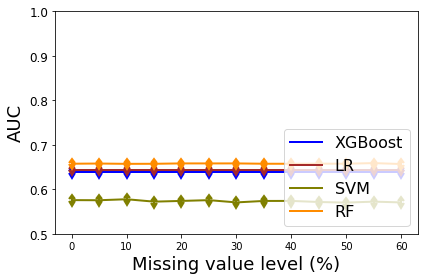

In [45]:
plt.figure(figsize=(6,4))
import numpy as np
import matplotlib.pyplot as plt

#plt.subplot(325)
x = missing_percentages

RF_Mean_Mode = df_AUC_rf.mean()
print(RF_Mean_Mode)
RF_Mean_Mode_etd_er = df_AUC_rf.sem(axis = 0)
LR_Mean_Mode = df_AUC_lr.mean()
LR_Mean_Mode_etd_er = df_AUC_lr.sem(axis = 0)
SVM_Mean_Mode = df_AUC_svm.mean()
SVM_Mean_Mode_etd_er = df_AUC_svm.sem(axis = 0)
XGB_Mean_Mode = df_AUC_xgb.mean()
XGB_Mean_Mode_etd_er = df_AUC_xgb.sem(axis = 0)

plt.plot(x, XGB_Mean_Mode,'b-',label='XGB_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, XGB_Mean_Mode, yerr=XGB_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='b', linewidth=2,capthick=2, uplims=True, lolims=True)

plt.plot(x, LR_Mean_Mode,'-',color ='brown',label='LR_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, LR_Mean_Mode, yerr=LR_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='brown',linewidth=2, capthick=2, uplims=True, lolims=True)

plt.plot(x, SVM_Mean_Mode,'-',color ='olive',label='SVM_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, SVM_Mean_Mode, yerr=SVM_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='olive', linewidth=2,capthick=2, uplims=True, lolims=True)

plt.plot(x, RF_Mean_Mode,'-',color = 'darkorange',label='RF_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, RF_Mean_Mode, yerr=RF_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='darkorange',linewidth=2, capthick=2,uplims=True, lolims=True)

plt.xlabel('Missing value level (%)', fontsize=18)
# plt.xticks(np.arange(0, 61, step=5),fontsize=12)
plt.yticks( fontsize=12)
plt.ylabel('AUC', fontsize=18)
plt.ylim([0.50,1.00])
plt.legend(( 'XGBoost','LR', 'SVM','RF'), loc='lower right', fontsize=16)

plt.tight_layout()
# save the figure in tiff file
plt.savefig(plot_path+"Figure_2A.tiff", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

# Figure 2B
## AUC of four classifiers with subset of feature selected by RFE (Section 3.1)

In [46]:
rfe_AUC_rf = pd.read_csv(result_path+'rfe_AUC_rf.csv')
rfe_AUC_lr = pd.read_csv(result_path+'rfe_AUC_lr.csv')
rfe_AUC_svm = pd.read_csv(result_path+'rfe_AUC_svm.csv')
rfe_AUC_xgb = pd.read_csv(result_path+'rfe_AUC_xgb.csv')

rfe_config = config['RFE']
total_num_feat = df_train_imputed_dropped_high_corr.shape[1]
if rfe_config['number_of_feature_to_select'] != 'ignore':
    rfe_num_features_list_str = parse_list(rfe_config['number_of_feature_to_select'])
    rfe_num_features_list_int = [int(s) for s in rfe_num_features_list_str]
elif rfe_config['step_size'] != 'ignore':
    rfe_num_features_list_int = list(range(1, total_num_feat, 
                                           int(rfe_config['step_size'])))
    if not total_num_feat in rfe_num_features_list_int:
        rfe_num_features_list_int.append(total_num_feat)
    rfe_num_features_list_int = rfe_num_features_list_int[::-1]
    rfe_num_features_list_str = [str(s) for s in rfe_num_features_list_str]

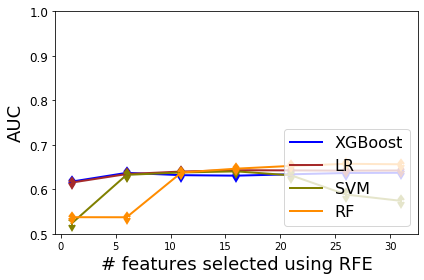

In [47]:
plt.figure(figsize=(6,4))
x = rfe_num_features_list_int

LR_Mean_Mode = rfe_AUC_lr.mean()
LR_Mean_Mode_etd_er = rfe_AUC_lr.sem(axis = 0)

RF_Mean_Mode = rfe_AUC_rf.mean()
RF_Mean_Mode_etd_er = rfe_AUC_rf.sem(axis = 0)

SVM_Mean_Mode = rfe_AUC_svm.mean()
SVM_Mean_Mode_etd_er = rfe_AUC_svm.sem(axis = 0)

XGB_Mean_Mode = rfe_AUC_xgb.mean()
XGB_Mean_Mode_etd_er = rfe_AUC_xgb.sem(axis = 0)

plt.plot(x, XGB_Mean_Mode,'b-',label='XGB_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, XGB_Mean_Mode, yerr=XGB_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='b', linewidth=2,capthick=2, uplims=True, lolims=True)

plt.plot(x, LR_Mean_Mode,'-',color ='brown',label='LR_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, LR_Mean_Mode, yerr=LR_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='brown',linewidth=2, capthick=2, uplims=True, lolims=True)

plt.plot(x, SVM_Mean_Mode,'-',color ='olive',label='SVM_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, SVM_Mean_Mode, yerr=SVM_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='olive', linewidth=2,capthick=2, uplims=True, lolims=True)

plt.plot(x, RF_Mean_Mode,'-',color = 'darkorange',label='RF_Mean_Mode',linewidth=2,markersize = 10)
plt.errorbar(x, RF_Mean_Mode, yerr=RF_Mean_Mode_etd_er, fmt='',linestyle='None', ecolor='darkorange',linewidth=2, capthick=2,uplims=True, lolims=True)

#plt.title('AUC', fontsize=24)
plt.xlabel('# features selected using RFE', fontsize=18)
# plt.xticks(np.arange(0, , fontsize=12)#, rotation=45)
plt.yticks( fontsize=12)
plt.ylabel('AUC', fontsize=18)
plt.ylim([0.5,1.00])
plt.legend(( 'XGBoost','LR', 'SVM','RF'), loc='lower right', fontsize=16)

plt.tight_layout()
# save the figure in tiff file
plt.savefig(plot_path+"Figure_2B.tiff", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

# Figure 3
## AUC plot of model trained by full set of features VS trained by optimal selected subset of feature(s)
This figure is to visualize the result of section 4 of prediction.

For example '3F model' means model used only 3 features, '17F model' means model used 17 features

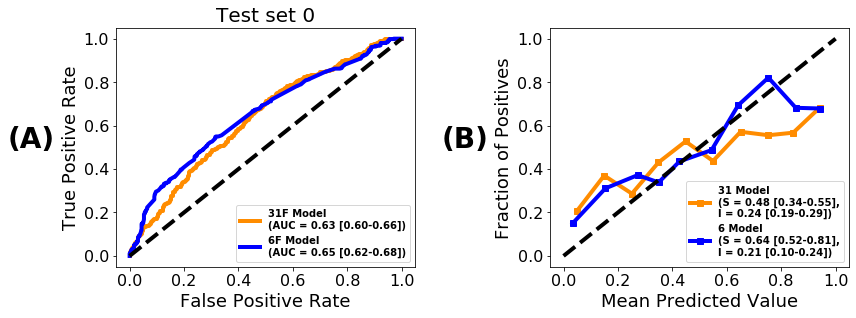

In [48]:
# bootstrapping AUC
def CI_auc(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    bootstrapped_scores = []
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    #    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 95% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    # print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(confidence_lower, confidence_upper))
    return auc, confidence_lower, confidence_upper

# Estimate slope and intercept of calibration curve
def params_calibration_curve(y_true, y_pred):
    fop, mpv = calibration_curve(y_true, y_pred, n_bins=10)
    ols = sm.OLS(fop, sm.add_constant(mpv)).fit()
    intercept, slope = ols.params
    return intercept, slope

# # bootstrapping slope and intercept
def CI_calibration_curve(y_true, y_pred):
    intercept, slope = params_calibration_curve(y_true, y_pred)
    bootstrapped_intercept = []
    bootstrapped_slope = []
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for cablibration curve
            # to be defined: reject the sample
            continue

        intercept, slope = params_calibration_curve(y_true[indices], y_pred[indices])
        bootstrapped_intercept.append(intercept)
        bootstrapped_slope.append(slope)


    sorted_intercept = np.array(bootstrapped_intercept)
    sorted_intercept.sort()

    sorted_slope = np.array(bootstrapped_slope)
    sorted_slope.sort()

    # Computing the lower and upper bound of the 95% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower_intercept = sorted_intercept[int(0.025 * len(sorted_intercept))]
    confidence_upper_intercept = sorted_intercept[int(0.975 * len(sorted_intercept))]

    confidence_lower_slope = sorted_slope[int(0.025 * len(sorted_slope))]
    confidence_upper_slope = sorted_slope[int(0.975 * len(sorted_slope))]
    return {'slope': [slope, confidence_lower_slope, confidence_upper_slope],
            'intercept': [intercept, confidence_lower_intercept, confidence_upper_intercept]}


config = configparser.ConfigParser()
config.read(config_fn)
config_IO = config['FileIO']
test_feature_fn_list = parse_list(config_IO['other_test_feature'])
test_label_fn_list = parse_list(config_IO['other_test_label'])
out_fn_format = config_IO['predicted_score_format']
out_fn_suffix_list = ['']
if test_feature_fn_list[0] != 'None':
    out_fn_suffix_list = out_fn_suffix_list + list(range(len(test_feature_fn_list)))

test_predictions_df_list = [result_path+out_fn_format.format(o) for o in out_fn_suffix_list]

df_list = [pd.read_csv(fn) for fn in test_predictions_df_list]

fig_size = (16,7)
fig1, ax = plt.subplots(len(df_list),2, figsize=(12,5*len(df_list)))

fig1.tight_layout(pad=5.0)
fig1.subplots_adjust(wspace=0.45, hspace=0.25)
label_fs = 18
lw = 4
legend_size = 12

n_bootstraps = 1000
rng_seed = 0  # control reproducibility
true_label_column = 'test_actual_label'
prediction_columns = df_list[0].columns.tolist()
prediction_columns.remove(true_label_column)

prediction_number_feature_used = [int(p.split('score_')[1].split('F_predicted')[0]) for p in prediction_columns]

sorted_zipped = sorted(list(zip(prediction_columns, prediction_number_feature_used)), key = lambda x: x[1])

prediction_number_feature_used = [x[1] for x in sorted_zipped]
prediction_columns = [x[0] for x in sorted_zipped]


data_dict = {'Test set {}'.format(i): [df[p] for p in prediction_columns] + [df['test_actual_label']] for i, df in enumerate(df_list)}

figure_start_letter = ord('A')


rng = np.random.RandomState(rng_seed)

for idx, (k, v) in enumerate(data_dict.items()):
    if len(data_dict) == 1:
        ax1 = ax[0]
        ax2 = ax[1]
    else:
        ax1 = ax[0, idx]
        ax2 = ax[1, idx]

    # plot AUC curve
    fpr_3f, tpr_3f, _ = roc_curve(v[-1], v[0])
    auc_3f, auc_3f_l, auc_3f_u = CI_auc(v[-1], v[0])

    fpr_17f, tpr_17f, _ = roc_curve(v[-1], v[1])
    auc_17f, auc_17f_l , auc_17f_u = CI_auc(v[-1], v[1])
    

    
    ax1.plot(fpr_17f, tpr_17f, 
             linewidth=lw,color='darkorange', 
             label='{}F Model\n(AUC = {:.2f} [{:.2f}-{:.2f}])'.format(prediction_number_feature_used[1], 
                                                                      auc_17f, auc_17f_l, auc_17f_u))
    ax1.plot(fpr_3f, tpr_3f, 
             linewidth=lw, color='blue', 
             label='{}F Model\n(AUC = {:.2f} [{:.2f}-{:.2f}])'.format(prediction_number_feature_used[0], 
                                                                      auc_3f, auc_3f_l, auc_3f_u))

    ax1.set_xlabel('False Positive Rate', fontsize=label_fs)
    ax1.set_ylabel('True Positive Rate', fontsize=label_fs)
    ax1.legend(fontsize=legend_size, prop=dict(weight='bold'))
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.plot([0, 1], [0, 1], lw=lw, color='black', linestyle='--')
#     if idx == 0:
    ax1.text(-0.45, 0.5, '({})'.format(chr(figure_start_letter+idx)), fontsize=28, weight='bold')
#     else:
#         ax1.text(-0.45, 0.5, '(B)', fontsize=28, weight='bold')
    ax1.set_title(k, fontsize=20)

    # plot calibration curve
    fop_3f, mpv_3f = calibration_curve(v[-1], v[0], n_bins=10)
    c3f = CI_calibration_curve(v[-1], v[0])
    c3f_s = c3f['slope']
    c3f_i = c3f['intercept']


    fop_17f, mpv_17f = calibration_curve(v[-1], v[1], n_bins=10)
    c17f = CI_calibration_curve(v[-1], v[1])
    c17f_s = c17f['slope']
    c17f_i = c17f['intercept']
    ax2.plot(mpv_17f, fop_17f, "s-", color='darkorange', linewidth=lw,
             label='{} Model\n(S = {:.2f} [{:.2f}-{:.2f}],\nI = {:.2f} [{:.2f}-{:.2f}])'.format(prediction_number_feature_used[1],
                                                                                                c17f_s[0], c17f_s[1], c17f_s[2],
                                                                                                          c17f_i[0], c17f_i[1], c17f_i[2]))
    ax2.plot(mpv_3f, fop_3f, "s-", color='blue', linewidth=lw,
             label='{} Model\n(S = {:.2f} [{:.2f}-{:.2f}],\nI = {:.2f} [{:.2f}-{:.2f}])'.format(prediction_number_feature_used[0],
                                                                                                c3f_s[0], c3f_s[1], c3f_s[2],
                                                                                                   c3f_i[0], c3f_i[1], c3f_i[2]))
    ax2.set_xlabel('Mean Predicted Value', fontsize=label_fs)
    ax2.set_ylabel('Fraction of Positives', fontsize=label_fs)
    ax2.legend(loc=4, fontsize=legend_size, prop=dict(weight='bold'))
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    ax2.text(-0.45, 0.5, '({})'.format(chr(figure_start_letter+len(data_dict)+idx)), fontsize=28, weight='bold')
#     if idx == 0:
#         ax2.text(-0.45, 0.5, '(C)', fontsize=28, weight='bold')
#     else:
#         ax2.text(-0.45, 0.5, '(D)', fontsize=28, weight='bold')


fig1.savefig(plot_path+'Figure3.tif', bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})

# Figure 4 A
## Visualizing the number times being selected as top N features by RFE in 300 runs
This figure is to visualize the result of section 3.2 of prediction.

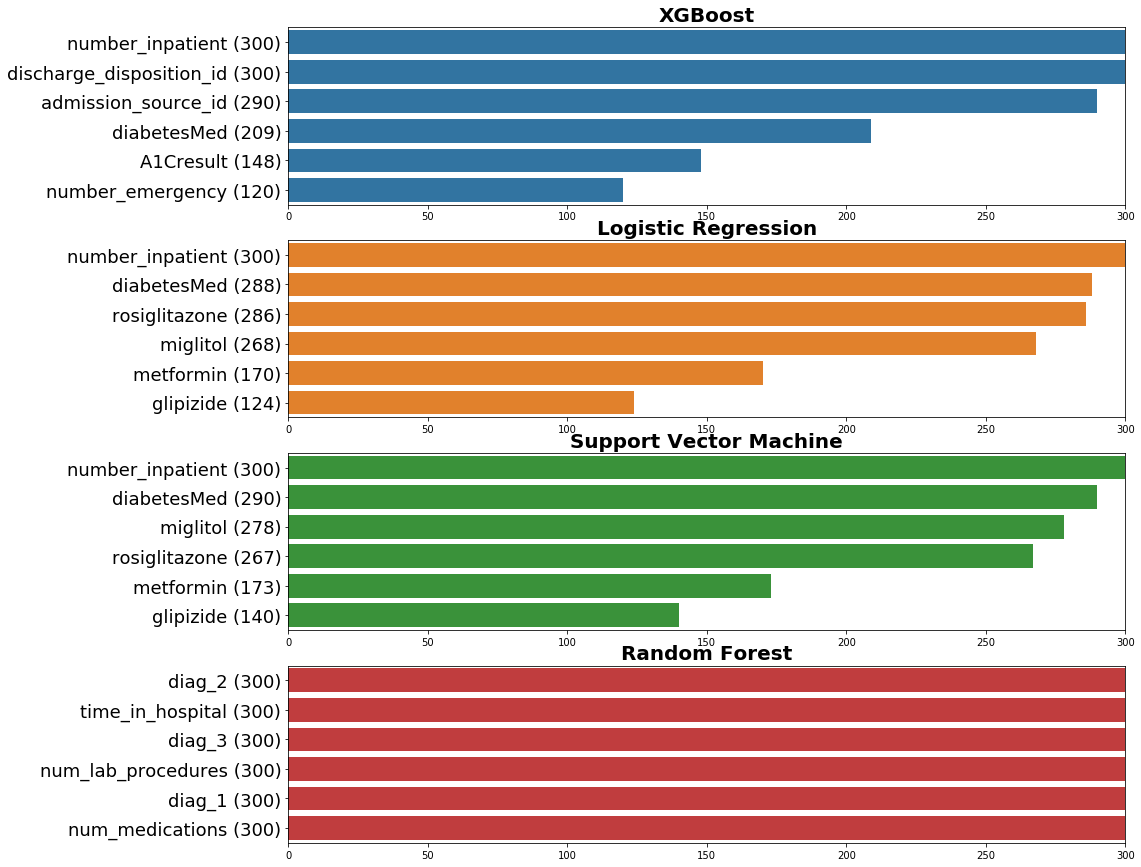

In [49]:
estimator_dict = {
            'XGBoost': XGBClassifier,
            'LR': LogisticRegression,
            'SVM': LinearSVC,
            'RF': RandomForestClassifier
}
cp = sns.color_palette(n_colors=len(estimator_dict))
all_result_df = pd.read_csv(result_path+'RFE_result.csv')
feature_name_list = list(df_train_imputed_dropped_high_corr.columns.values)
estimator_full_name_dict = {'XGBoost': 'XGBoost',
            'LR': 'Logistic Regression',
            'SVM': 'Support Vector Machine',
            'RF': 'Random Forest'}

three_set_of_seed = [range(100), range(100,200), range(200,300)]

# histogram plot
top_n_list = no_features_to_pick_list
bar_color_list = ['b', 'brown', 'olive', 'darkorange']
for top_n in top_n_list:
    top_n_df = all_result_df[all_result_df['num_features_picked'] == top_n]
    freq_df_list = []
    freq_df = pd.DataFrame(columns=['set_to_run', 'classifier', 'freq', 'feature'])
    feature_frequency_dict_by_clf = dict()
    fig2, axs = plt.subplots(4, figsize=(15,15))
    top_n_df_by_seed_set = top_n_df
    for est_idx, (est_name, est) in enumerate(estimator_dict.items()):
        top_n_df_by_clf = top_n_df_by_seed_set[top_n_df_by_seed_set['classifier']==est_name]

        for idx, f_name in enumerate(feature_name_list):
            freq = sum(top_n_df_by_clf[f_name].values)
            dict_to_append = {'classifier': est_name,
                              'freq': freq, 'feature': f_name}
            freq_df = freq_df.append(dict_to_append, ignore_index=True)


        freq_df_est = freq_df[freq_df['classifier']==est_name]
        freq_df_est = freq_df_est.sort_values(by=['freq'], ascending=False).iloc[:top_n]
        axs[est_idx] = sns.barplot(ax=axs[est_idx], x="freq", y="feature", data=freq_df_est, orient='h', color=cp[est_idx])
#         axs[est_idx].barh(range(top_n), freq_df_est['freq'], color=bar_color_list[est_idx], edgecolor = 'k')
        axs[est_idx].set_yticks(range(top_n))
        axs[est_idx].set_title(estimator_full_name_dict[est_name], fontweight='bold',fontsize = 20)
#         axs[est_idx].set_xticks(range(three_set_of_seed[-1][-1]+1))
        axs[est_idx].set_xlim([0, three_set_of_seed[-1][-1]+1])
        axs[est_idx].set_xlabel('')
        new_yticks_label = []
        axs[est_idx].set_ylabel('')
        for idx, yticks in enumerate(axs[est_idx].get_yticklabels()):
            new_yticks_label.append("{} ({})".format(yticks.get_text(), freq_df_est['freq'].iloc[idx]))
        axs[est_idx].set_yticklabels(new_yticks_label, fontsize=18)
    fig2.savefig(plot_path+'Figure_4A_top{}_frequency_by_clf.tif'.format(top_n), 
                 bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})


# Supplementary Figure 1A, 1B, 1C
## Visualizing the number times being selected as top N features by RFE in 3 set of 100 runs
This figure is to visualize the result of section 3.2 of prediction.

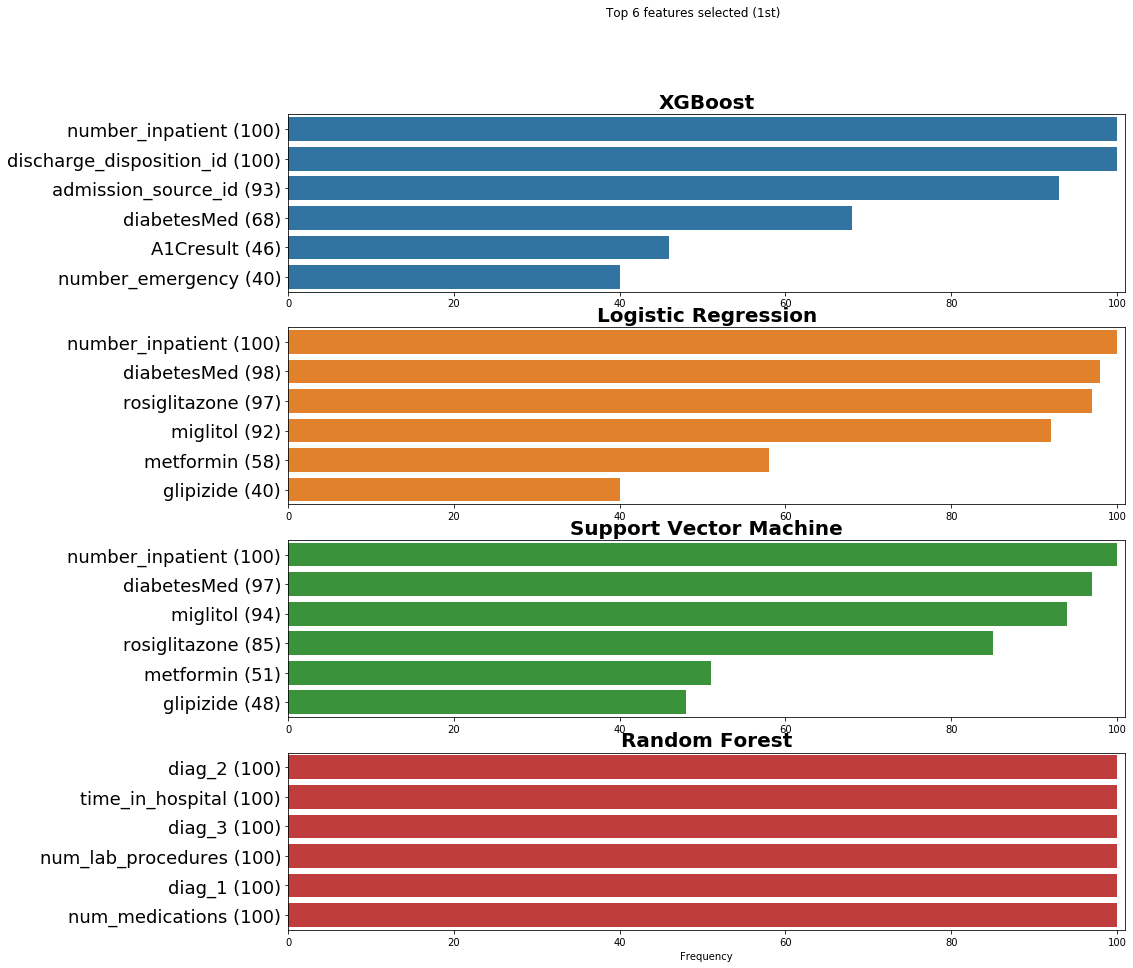

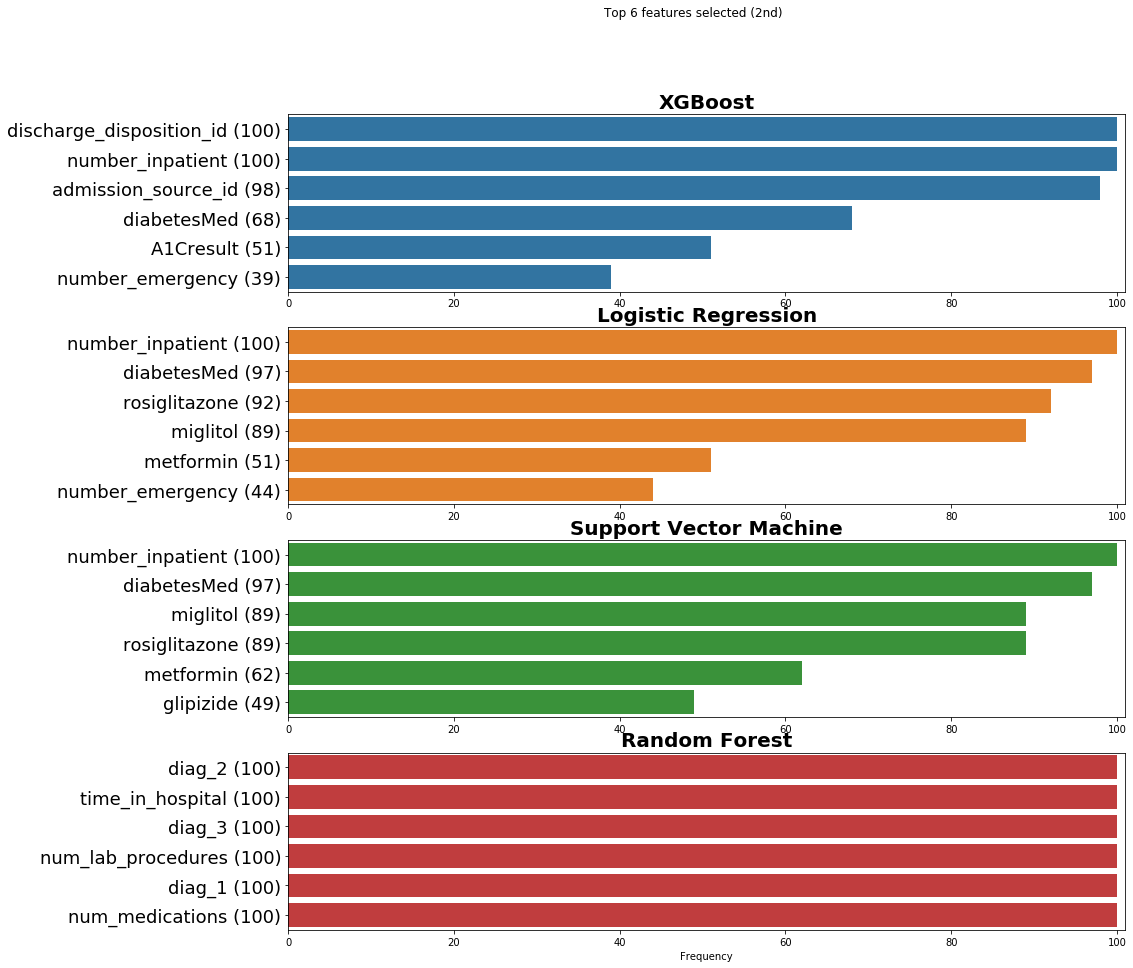

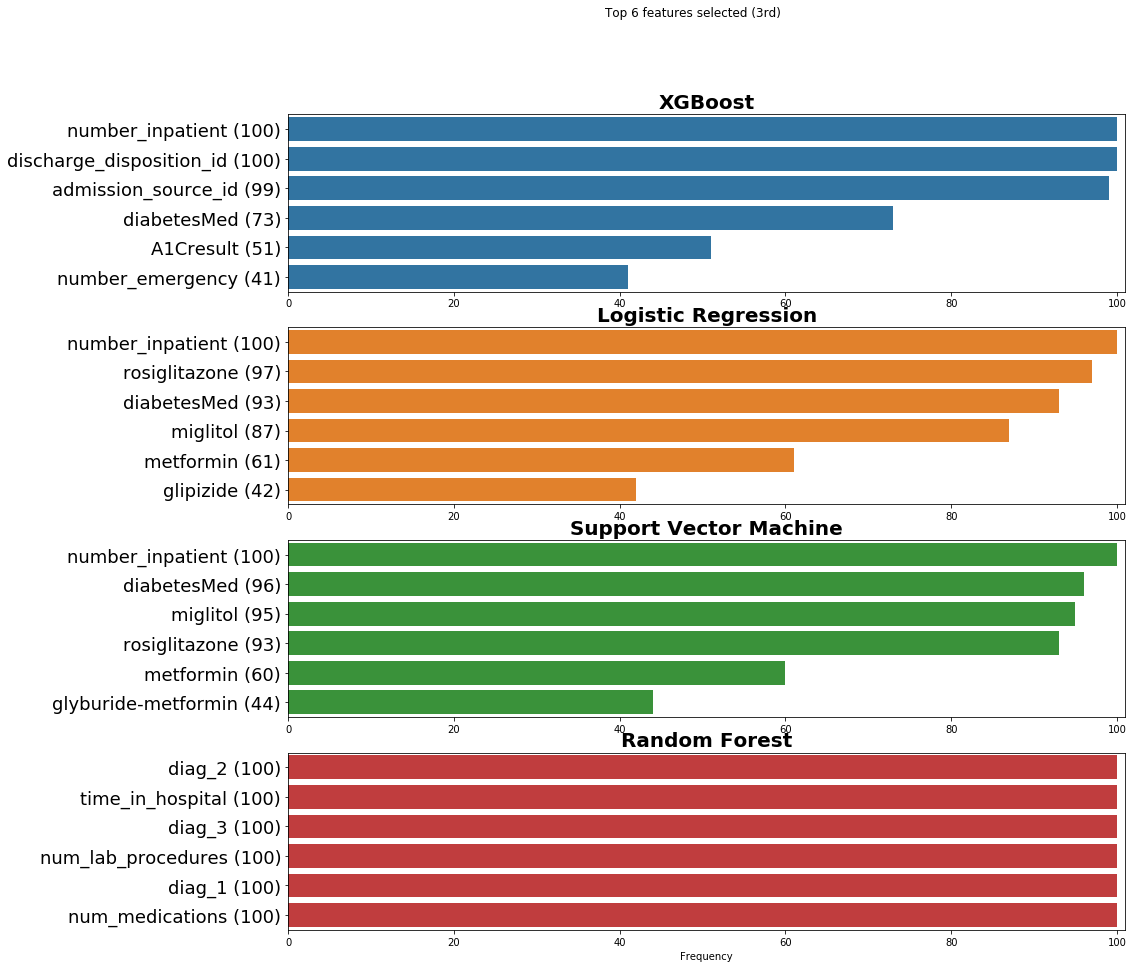

In [50]:
def make_ordinal(n):
    '''
    Convert an integer into its ordinal representation::

        make_ordinal(0)   => '0th'
        make_ordinal(3)   => '3rd'
        make_ordinal(122) => '122nd'
        make_ordinal(213) => '213th'
    '''
    n = int(n)
    suffix = ['th', 'st', 'nd', 'rd', 'th'][min(n % 10, 4)]
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    return str(n) + suffix

for top_n in top_n_list:
    top_n_df = all_result_df[all_result_df['num_features_picked'] == top_n]
    freq_df_list = []
    for set_idx, set_of_seed in enumerate(three_set_of_seed):
        freq_df = pd.DataFrame(columns=['set_to_run', 'classifier', 'freq', 'feature'])
        feature_frequency_dict_by_clf = dict()
        fig2, axs = plt.subplots(4, figsize=(15,15))


        in_seed_range = (top_n_df['seed'] <= set_of_seed[-1]) & (top_n_df['seed'] >= set_of_seed[0])
        top_n_df_by_seed_set = top_n_df[in_seed_range]


        for est_idx, (est_name, est) in enumerate(estimator_dict.items()):
            top_n_df_by_clf = top_n_df_by_seed_set[top_n_df_by_seed_set['classifier']==est_name]
            
            for idx, f_name in enumerate(feature_name_list):
                freq = sum(top_n_df_by_clf[f_name].values)
                dict_to_append = {'set_to_run': set_idx, 'classifier': est_name,
                                  'freq': freq, 'feature': f_name}
                freq_df = freq_df.append(dict_to_append, ignore_index=True)


            freq_df_est = freq_df[freq_df['classifier']==est_name]
            freq_df_est = freq_df_est.sort_values(by=['freq'], ascending=False).iloc[:top_n]
            axs[est_idx] = sns.barplot(ax=axs[est_idx], x="freq", y="feature", data=freq_df_est, orient='h', color=cp[est_idx])
#             axs[est_idx].barh(range(top_n), freq_df_est['freq'], color=bar_color_list[est_idx], edgecolor = 'k')
            axs[est_idx].set_title(estimator_full_name_dict[est_name], fontweight='bold',fontsize = 20)
#             axs[est_idx].set_xticks(range(len(set_of_seed)+1))
            axs[est_idx].set_xlim([0, len(set_of_seed)+1])
            axs[est_idx].set_xlabel('')
            new_yticks_label = []
            axs[est_idx].set_ylabel('')
            for idx, yticks in enumerate(axs[est_idx].get_yticklabels()):
                new_yticks_label.append("{} ({})".format(yticks.get_text(), freq_df_est['freq'].iloc[idx]))
                axs[est_idx].set_yticklabels(new_yticks_label, fontsize=18)
            
            if est_idx < len(estimator_dict)-1:
                axs[est_idx].set_xlabel('')
            else:
                axs[est_idx].set_xlabel('Frequency')
        fig2.suptitle('Top {} features selected ({})'.format(top_n, make_ordinal(set_idx+1)))
        fig2.savefig(plot_path+'Sup_Fig1{}_top{}_frequency_by_clf.tif'.format(chr(figure_start_letter+set_idx), top_n), 
                     bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})